# Detector de claretat en cosos d'aigua

Per a detectar la claretat en cosos d'aigua hem fet servir les bandes Red(B04) i Green(B03) del satèlit Sentinel2_L2A. 

Hem aplicat el criteri: $\frac{Canal Vermell}{Canal Verd}$ per a determinar el factor de terbolesa, es a dir, la opacitat de l'aigua, es a dir, el contrari de clar o nítid. Per lo tant ens agraden uns valors de terbolesa baixos. 

Un alt factor de terbolesa voldrà dir que hi ha moltes particules en suspensió a l'aigua, aquestes poden ser naturals, biologiques o artificials.

A continuació mostrem els passos que hem seguit per a determinar aquest indicador:

## 0. Connexió i dades d'entrada

Abans de res cal fer tots els imports, crear una conexió amb el backend de la llibreria openeo i determinar algunes (si no totes) dades variables per a que desprès la lectura i execució del codi sigui més fluida.

In [26]:
import openeo # https://openeo.org/documentation/1.0/python/#collections


# --- Connexió al "Backend"
backend = "openeo.dataspace.copernicus.eu"
conn = openeo.connect(backend).authenticate_oidc()

# --- Dades d'entrada
satelit="SENTINEL2_L2A"
spatial_extent = {
    "west": 3.123732,
    "east": 3.333247,
    "south": 42.123212,
    "north": 42.255935,
}
temporal_extent = ["2023-01-01", "2024-01-01"] # Les dates estàn en notació: aaaa-mm-dd 
bands=["B03", "B04"]
max_cloud_coverage = 0

directori_dades = "output/claretat_mapes_golf_de_roses/"
fitxer_animacio = "output/Animacions/animacio_calretat_golf_de_roses.gif"

Authenticated using refresh token.


## 1. Descarregar les dades satelitals i aplicar criteri

En aquest primer pass farèm servir els serveis de openeo per a descarregar totes les dades que necessitem.

In [27]:
datacube = conn.load_collection(
    satelit,
    spatial_extent=spatial_extent,
    temporal_extent= temporal_extent,
    bands=bands,
    max_cloud_cover=max_cloud_coverage,
)

# Normalitzem les dades (se suposa que estan 0-10.000)
datacube = datacube.apply(lambda x: x / 10000)

canal_vermell = datacube.band("B04")
canal_verd = datacube.band("B03")

# Apliquem el criteri
claretat =  canal_vermell / canal_verd 


result = claretat.save_result("GTiff") 

job = result.create_job()
job.start_and_wait()
job.get_results().download_files(directori_dades)

0:00:00 Job 'j-240915f75aaa4f078156711a3a52fb18': send 'start'
0:00:18 Job 'j-240915f75aaa4f078156711a3a52fb18': created (progress 0%)
0:00:23 Job 'j-240915f75aaa4f078156711a3a52fb18': created (progress 0%)
0:00:29 Job 'j-240915f75aaa4f078156711a3a52fb18': created (progress 0%)
0:00:37 Job 'j-240915f75aaa4f078156711a3a52fb18': created (progress 0%)
0:00:47 Job 'j-240915f75aaa4f078156711a3a52fb18': running (progress N/A)
0:01:00 Job 'j-240915f75aaa4f078156711a3a52fb18': running (progress N/A)
0:01:16 Job 'j-240915f75aaa4f078156711a3a52fb18': running (progress N/A)
0:01:35 Job 'j-240915f75aaa4f078156711a3a52fb18': running (progress N/A)
0:01:59 Job 'j-240915f75aaa4f078156711a3a52fb18': running (progress N/A)
0:02:39 Job 'j-240915f75aaa4f078156711a3a52fb18': running (progress N/A)
0:03:16 Job 'j-240915f75aaa4f078156711a3a52fb18': running (progress N/A)
0:04:03 Job 'j-240915f75aaa4f078156711a3a52fb18': finished (progress 100%)


[PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-01-02Z.tif'),
 PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-01-07Z.tif'),
 PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-01-17Z.tif'),
 PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-01-22Z.tif'),
 PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-01-27Z.tif'),
 PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-02-01Z.tif'),
 PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-02-06Z.tif'),
 PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-02-11Z.tif'),
 PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-02-16Z.tif'),
 PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-02-21Z.tif'),
 PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-02-26Z.tif'),
 PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-03-03Z.tif'),
 PosixPath('output/claretat_mapes_golf_de_roses/openEO_2023-03-08Z.tif'),
 PosixPath('output/claretat_mapes_golf

## 2. Creem histograma 

A partir de les imatges descarregades farèm un histograma de la claredat mitjana cada dia.

Text(0, 0.5, 'Mitjanes')

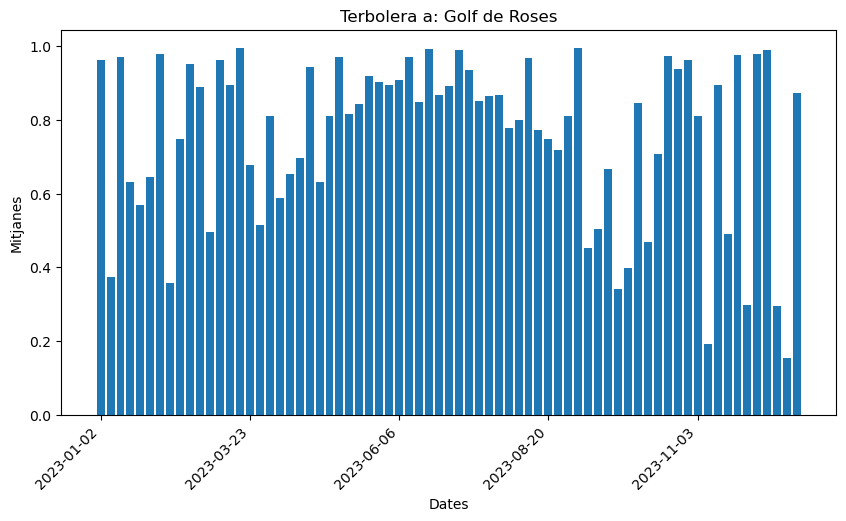

In [28]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

fitxers = sorted([f for f in os.listdir(directori_dades) if f.endswith('.tif')])

day_means_dict = {}

# --- Extraiem les dades dels fitxers, calculem les seves mitjanes diaries i les guardem en un diccionari
for fitxer in fitxers:
    # Extraiem la data i la mitjana diaria
    data = fitxer.split("_")[1].replace("Z.tif", "")
    with rasterio.open(directori_dades+fitxer) as dades_fitxer:
        dades = dades_fitxer.read(1)  
        mitja = np.nanmean(dades)
        day_means_dict.update({data : mitja})
        
# --- Creem l'histograma
 
dates = list(day_means_dict.keys())
mitjes = list(day_means_dict.values())


plt.figure(figsize=(10, 5))
plt.bar(dates, mitjes)
plt.title('Terbolera a: Golf de Roses')
plt.xticks(ticks=range(0, len(dates), 15), labels=[dates[i] for i in range(0, len(dates), 15)], rotation=45, ha="right")
plt.xlabel('Dates')
plt.ylabel('Mitjanes')

## 4. Creem la animació

Per a crear la animació simplement 

MovieWriter ffmpeg unavailable; using Pillow instead.
TIFFReadDirectory: Warning, Unknown field with tag 33550 (0x830e) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 33922 (0x8482) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34735 (0x87af) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42112 (0xa480) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 33550 (0x830e) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 33922 (0x8482) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34735 (0x87af) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42112 (0xa480) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 33550 (0x830e) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 33922 (0x8482) encountered

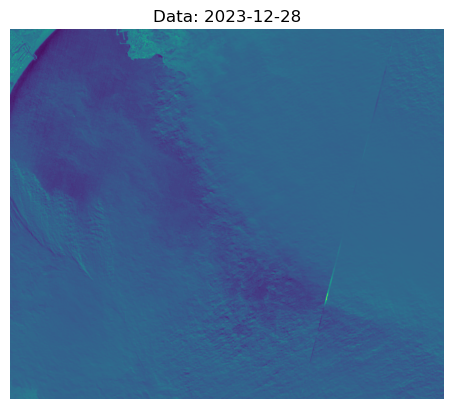

In [29]:
from libtiff import TIFF
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

# Fem una llista amb tots els noms dels fitxers del directori d'imatges
image_files = sorted([f for f in os.listdir(directori_dades) if f.endswith('.tif')])

def load_image(file_path):
    tif = TIFF.open(directori_dades+file_path) 
    return tif.read_image()

# Create figure and axes
fig, ax = plt.subplots()

def update(frame):
    """Update the frame for the animation."""   
    
    rgb_image = load_image(image_files[frame])
    ax.clear()
    ax.imshow(rgb_image)
    ax.set_title(f"Data: {dates[frame]}")
    ax.axis('off')
    
ani = animation.FuncAnimation(fig, update, frames=len(image_files), repeat=True, interval=200)

# Save the animation as a gif or mp4
ani.save(fitxer_animacio, writer='ffmpeg', fps=2)

plt.show()